Mapping daily cumulative cases over time using the John Hopkins map data.

In [175]:
from datetime import datetime, timedelta
import json

from keplergl import KeplerGl
import pandas as pd

In [3]:
DATA_URI = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

In [47]:
!wget $DATA_URI

--2020-05-02 13:09:59--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
Resolving raw.githubusercontent.com... 151.101.64.133, 151.101.128.133, 151.101.192.133, ...
Connecting to raw.githubusercontent.com|151.101.64.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26254 (26K) [text/plain]
Saving to: 'time_series_covid19_confirmed_global.csv.1'

time_series_covid19 100%[===================>]  25.64K  --.-KB/s    in 0.005s  

2020-05-02 13:09:59 (5.15 MB/s) - 'time_series_covid19_confirmed_global.csv.1' saved [88599]



In [183]:
df = pd.read_csv("time_series_covid19_confirmed_global.csv")
df["Province/State"] = df["Province/State"].fillna("")
if df["Country/Region"].isnull().any():
    print("Found at least 1 NULL Country/Region - to be investigated.")

id_vars = ["Province/State", "Country/Region", "Lat", "Long"]
date_cols = [c for c in df.columns if c not in id_vars]
dfm = df.melt(id_vars, date_cols, "Date")
# dfm = dfm.rename(columns={"value": "cumulative"})

dfm["Datetime"] = pd.to_datetime(dfm["Date"])
# Need String date for sensible display inside Kepler.gl tooltips:
dfm["Date"] = dfm["Datetime"].dt.strftime("%Y-%m-%d")  
dfm.head()

,Province/State,Country/Region,Lat,Long,Date,value,Datetime
0,,Afghanistan,33.0000,65.0000,2020-01-22,0,2020-01-22
1,,Albania,41.1533,20.1683,2020-01-22,0,2020-01-22
2,,Algeria,28.0339,1.6596,2020-01-22,0,2020-01-22
3,,Andorra,42.5063,1.5218,2020-01-22,0,2020-01-22
4,,Angola,-11.2027,17.8739,2020-01-22,0,2020-01-22


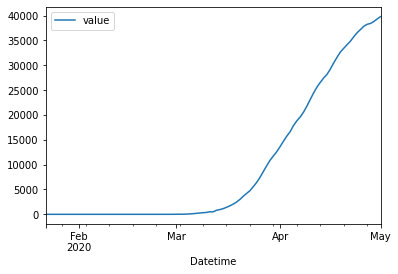

In [184]:
import matplotlib.pyplot as plt
%matplotlib inline

data_nl = dfm[(dfm["Country/Region"] == "Netherlands") & (dfm["Province/State"] == "")]
data_nl.plot(x="Datetime", y="value")
# plt.yscale("log")
# plt.xscale("log")

In [195]:
KEPLER_CONF = "kepler-config-jh-data-cumulative.json"

with open(KEPLER_CONF, "r") as fp:
    config = json.load(fp)

jh_map = KeplerGl(
    height=800, 
    data={"data": dfm},
    config=config
)
jh_map


User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': 'data', 'id': 'ajbff39ms', 'n…

In [194]:
with open(KEPLER_CONF, "w") as fp:
    json.dump(jh_map.config, fp)

Use this to set a sensible timeRange and edit the config JSON manually:

In [190]:
def to_unixtime(timestamp):
    unix_timestamp = int(timestamp.strftime("%s")) * 1000
    print(f"{timestamp} --> {unix_timestamp}")

In [191]:
start = datetime(2020, 3, 1)
to_unixtime(start)
to_unixtime(start + timedelta(hours=23, minutes=59, seconds=59))

2020-03-01 00:00:00 --> 1583017200000
2020-03-01 23:59:59 --> 1583103599000


In [196]:
jh_map.save_to_html(
    data={"data": 
          # Can't serialize pd.Timestamp to JSON, so need to convert explicitly:
          dfm.assign(
              Datetime=lambda df: df["Datetime"].dt.strftime("%Y-%m-%dT%H:%M:%S")
          )
         },
         # Takes the static config, not the one with possibly recent changes made in the GUI:
         config=config)

Map saved to keplergl_map.html!
